<a href="https://colab.research.google.com/github/Ibsen-Gomes/Deep_learning_Colab/blob/main/Deep_learning_breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import torch
torch.__version__

'2.0.1+cu118'

In [3]:
import torch.nn as nn

### Load data

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
previsores = pd.read_csv('/content/entradas_breast.csv')
classe = pd.read_csv('/content/saidas_breast.csv')

In [6]:
previsores.shape

(569, 30)

In [7]:
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [8]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [9]:
np.unique(classe)

array([0, 1])

<Axes: xlabel='0', ylabel='count'>

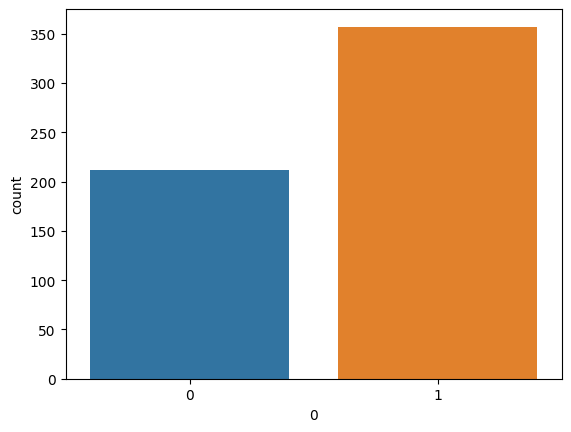

In [10]:
sns.countplot(x=classe['0'])

In [11]:
previsores_train, previsores_test, classe_train, classe_test = train_test_split(previsores,
                                                                               classe,
                                                                               test_size = 0.25)

In [12]:
previsores_train.shape

(426, 30)

In [13]:
classe_train.shape

(426, 1)

In [14]:
previsores_test.shape

(143, 30)

In [15]:
classe_test.shape

(143, 1)

### Transformação em tensores:

##### Essencial para processamento em GPUs

In [16]:
type(previsores_train)

pandas.core.frame.DataFrame

In [17]:
type(np.array(previsores_train))

numpy.ndarray

In [18]:
previsores_train = torch.tensor(np.array(previsores_train), dtype = torch.float)
classe_train = torch.tensor(np.array(classe_train), dtype = torch.float)

In [19]:
type(previsores_train)

torch.Tensor

In [20]:
type(classe_train)

torch.Tensor

#### Criação de um dataset com união dos previsres e classes:

In [21]:
dataset = torch.utils.data.TensorDataset(previsores_train, classe_train)

In [22]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [23]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

### Construção do modelo:

In [24]:
# 30 neurônios no input = 30 atributos previsores
# 16 neurônios 1° camada oculta
# 16 neurônios 2° camada oculta
# pq 16 neurônios nas redes ocultas? -> (entradas + saídas) / 2 = (30+1)/2 = 16
# 1 neurônio na camada de saída (probabilidade de uma classe 0 ou 1)

classificador = nn.Sequential( # sequencia de camada

    nn.Linear(in_features=30, out_features=16,), # Linear = todas as camadas de entrada ligado a todos de saída
    nn.ReLU(), # função de ativação aplicado no 1° camdada de 16 neurônios

    nn.Linear(16, 16), # Linear = todas as 16 camadas ligadas aos próximos 16 neurônios
    nn.ReLU(), # função de ativação aplicado no 2° camada de 16 neurônios

    nn.Linear(16, 1), # Linear = todas as 16 camadas ligadas ao neurônio de saída
    nn.Sigmoid(), # função de ativação na camada com 1 neurônio
)


In [25]:
# observar a estrutura da rede neural:

classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [26]:
# Função de erro:

criterion = nn.BCELoss()
# Binary cross entropy (comparação entre previsão e gabarito)

In [27]:
# Otimizador

optimizer = torch.optim.Adam(classificador.parameters(),
                             lr = 0.001, # taxa de aprendizado
                             weight_decay = 0.0001) # decaimento dos pesos
                             # diminui lr com o passar das epocas

In [28]:
# Necessário um For para treinamento (diferente do TensorFLow ou Sklearn que tem um fit)
for epoch in range(100): # Em 1 epoca passando por 426 registros de 10 em 10 (batch) registros
  running_loss = 0. # Inicializar o acumulador do erro

  for data in train_loader: # train_loader = dados dividido em 10 em 10 registros

    inputs, labels = data # inputs=previsores e labels=classes
    optimizer.zero_grad() # zerar, pq em cada ajuste de peso é necessario calcular o gradiente separadamente

    outputs = classificador(inputs) #passando os inputs no modelo e gerando os outputs -> processo forward na rede (esqeurda p/ direita)
    # outputs-> classificador.forward(inputs)
    loss = criterion(outputs, labels) #calculo do erro entre labels reais e preditos
    loss.backward() #voltando e atualizando os pesos processo de backward na rede (direita p/ esquerda)
    optimizer.step() #atualização dos pesos usando o "Adam"

    running_loss += loss.item() #somatorio do erro
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))


Época   1: perda 10.76845
Época   2: perda 2.76033
Época   3: perda 1.41596
Época   4: perda 0.70450
Época   5: perda 0.68355
Época   6: perda 0.38389
Época   7: perda 0.60377
Época   8: perda 0.28244
Época   9: perda 0.25952
Época  10: perda 0.24751
Época  11: perda 0.31085
Época  12: perda 0.23567
Época  13: perda 0.25210
Época  14: perda 0.23270
Época  15: perda 0.23848
Época  16: perda 0.20633
Época  17: perda 0.24387
Época  18: perda 0.28400
Época  19: perda 0.22199
Época  20: perda 0.22885
Época  21: perda 0.19840
Época  22: perda 0.26132
Época  23: perda 0.27163
Época  24: perda 0.22426
Época  25: perda 0.26579
Época  26: perda 0.22590
Época  27: perda 0.20857
Época  28: perda 0.20451
Época  29: perda 0.20278
Época  30: perda 0.20289
Época  31: perda 0.23885
Época  32: perda 0.19190
Época  33: perda 0.24389
Época  34: perda 0.38608
Época  35: perda 0.23924
Época  36: perda 0.26869
Época  37: perda 0.22983
Época  38: perda 0.35327
Época  39: perda 0.41073
Época  40: perda 0.23598

### Visuzalização dos pesos:

In [29]:
params = list(classificador.parameters())


In [30]:
pesos0 = params[0]
pesos0.shape

torch.Size([16, 30])

In [31]:
# ligação (pesos) entre todas os 30 inputs da camadas de entrada com os 16 neurônios da primeira camada oculta
print(pesos0)

Parameter containing:
tensor([[-6.7048e-02,  1.2647e-01, -2.6380e-01,  8.0228e-02, -2.1038e-02,
          7.3645e-02, -3.8682e-02,  6.4476e-03,  4.6320e-02, -4.8976e-04,
          1.5157e-01,  3.8141e-02,  9.7813e-02,  9.5630e-02,  8.0925e-03,
         -1.7582e-01,  1.4276e-01, -1.4056e-01,  6.8774e-02,  2.6168e-01,
         -3.2357e-01,  4.1727e-02, -2.4658e-01,  6.9130e-02, -2.9534e-01,
         -1.2235e-01, -2.5240e-01, -1.6792e-01, -1.5795e-01,  5.0240e-02],
        [ 1.1476e-01, -1.5002e-01, -3.9405e-02,  6.4891e-05,  9.1534e-02,
          7.2517e-02,  8.4780e-02,  1.1925e-01, -2.8373e-02, -6.8649e-02,
          9.2078e-02, -2.1361e-02,  6.9109e-02,  1.2491e-01,  2.4290e-02,
         -2.1839e-01,  1.1823e-01, -1.9843e-01,  1.1583e-01,  1.8124e-01,
         -3.7764e-01,  2.6967e-02, -2.6733e-01,  1.6276e-01,  4.6862e-02,
          7.9380e-02,  2.8672e-02,  4.0246e-02,  1.2518e-01,  1.0407e-01],
        [ 4.3195e-02, -2.5811e-01,  1.4246e-01, -7.2937e-02, -1.6527e-01,
          1.22

In [32]:
# Unidade de bias na 1° camada oculta
bias0 = params[1]
bias0.shape

torch.Size([16])

In [33]:
# ligação (pesos) entre todas os 16 neurônios da primeira camada oculta com os 16 neurônios da segunda camada oculta.
pesos1 = params[2]
pesos1.shape

torch.Size([16, 16])

In [34]:
# Unidade de bias na 2° camada oculta
bias1 = params[3]
bias1.shape

torch.Size([16])

### Avaliação do modelo:

In [35]:
classificador.eval() # .eval = significa que o classificador em modo avaliação


Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [36]:
type(previsores_test)

pandas.core.frame.DataFrame

In [37]:
previsores_test = torch.tensor(np.array(previsores_test), dtype=torch.float)

In [38]:
type(previsores_test)

torch.Tensor

In [39]:
previsoes = classificador.forward(previsores_test) # passar pela rede neural em forward

In [40]:
# probabilidade entre 0 e 1
previsoes

tensor([[1.7379e-01],
        [7.1350e-10],
        [1.1734e-04],
        [9.9992e-01],
        [8.8177e-01],
        [5.2573e-12],
        [3.1515e-09],
        [1.3328e-01],
        [9.8356e-01],
        [8.7446e-01],
        [9.0748e-01],
        [6.1902e-04],
        [5.6222e-01],
        [5.0661e-02],
        [1.0000e+00],
        [5.4049e-01],
        [9.7615e-01],
        [9.9335e-01],
        [1.0000e+00],
        [3.2630e-07],
        [1.4201e-04],
        [8.5586e-01],
        [9.8900e-12],
        [9.9822e-01],
        [9.3698e-01],
        [9.8806e-01],
        [9.9266e-01],
        [9.9158e-01],
        [7.5648e-01],
        [4.4503e-09],
        [9.9648e-01],
        [9.8840e-01],
        [1.0000e+00],
        [1.5677e-01],
        [9.9731e-01],
        [9.9826e-01],
        [2.6660e-04],
        [5.1431e-01],
        [2.2537e-07],
        [2.1144e-01],
        [9.7095e-01],
        [8.0252e-04],
        [9.5313e-01],
        [4.4876e-01],
        [9.9789e-01],
        [9

In [41]:
# Limiar de classificação

previsoes = np.array(previsoes> 0.5) # valor 0.5 de acordo com o cenário
previsoes

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [

In [42]:
previsoes.shape

(143, 1)

In [43]:
classe_test

,0
204,1
70,0
131,0
431,1
540,1
...,...
89,1
199,0
411,1
18,0


In [45]:
# Taxa de acerto, comparação entre as etiquetas 0 e 1 com as str True e False:

taxa_acerto = accuracy_score(classe_test, previsoes)
taxa_acerto

0.8881118881118881

In [46]:
# Matrix de confusão:

matrix = confusion_matrix(classe_test, previsoes)
matrix

array([[49,  5],
       [11, 78]])

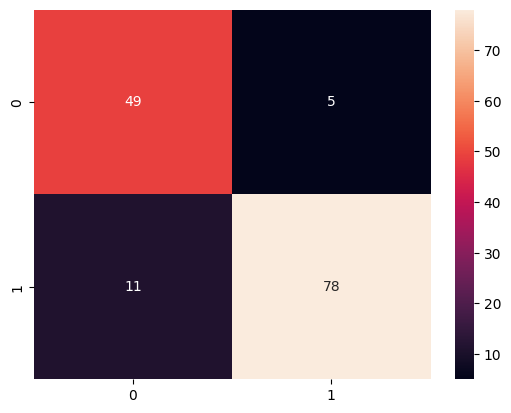

In [48]:
sns.heatmap(matrix, annot=True);